In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import xgboost as xgb

In [42]:
df = pd.read_csv("datasets/2022-dataset1.csv")
df2 = pd.read_csv("datasets/2022-dataset2.csv")

In [43]:
df1_cols = list(df.columns)
df2_cols = list(df2.columns)

list(set(df1_cols)-set(df2_cols))

['loan_late_fee_to_date',
 'loan_status',
 'loan_interest_to_date',
 'loan_remaining_principal',
 'collection_fee',
 'loan_principal_to_date',
 'loan_recovery',
 'loan_issue_date',
 'loan_total_payment']

In [44]:
df.drop(columns=['loan_remaining_principal',
 'collection_fee',
 'loan_late_fee_to_date',
 'loan_issue_date',
 'loan_total_payment',
 'loan_status',
 'loan_interest_to_date',
 'loan_recovery',
 'loan_principal_to_date'])
df

,delinquent_accounts,borrower_state,annual_income,marital_status,default_12months,collection_fee,collections_12months,delinquent_2years,delinquent_amount,loan_description,...,collection_total_amount,fi_total_all_account,loan_total_payment,loan_interest_to_date,loan_late_fee_to_date,loan_principal_to_date,annual_income_verified,borrower_zipcode,gender,age
0,0,CA,42000.0,Single,0,0.0,0,0,0,NaN,...,0,16,6397.93,1086.24,0.00,5311.69,Source Verified,923xx,1,48.0
1,0,VA,79077.0,Single,0,0.0,0,0,0,NaN,...,0,20,8511.19,1429.00,0.00,7082.19,Not Verified,223xx,1,45.0
2,0,TX,107000.0,Married,0,0.0,0,0,0,NaN,...,0,52,18371.72,2760.35,0.00,15611.37,Verified,750xx,2,50.0
3,0,NJ,155000.0,Single,0,0.0,0,2,0,NaN,...,0,42,19086.15,4513.90,0.00,14572.25,Source Verified,080xx,1,56.0
4,0,TX,120000.0,Single,0,0.0,0,0,0,NaN,...,0,26,17080.81,8037.02,0.00,9043.79,Verified,778xx,1,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877981,0,AL,95000.0,Single,0,0.0,0,0,0,NaN,...,0,54,15760.50,6047.89,0.00,9712.61,Source Verified,356xx,1,43.0
877982,0,UT,108000.0,Single,0,0.0,0,0,0,NaN,...,0,58,15008.53,4959.95,0.00,10048.58,Not Verified,840xx,2,51.0
877983,0,CA,227000.0,Single,0,0.0,0,7,0,NaN,...,0,37,24903.93,8156.52,0.00,16747.41,Verified,907xx,2,55.0
877984,0,FL,110000.0,Single,0,0.0,0,0,0,NaN,...,0,31,6755.40,3233.49,0.00,3521.91,Not Verified,334xx,2,35.0


In [45]:
usable_df = pd.concat([df, df2], axis=0)
usable_df = usable_df.drop(columns=["loanID", "collection_fee", "loan_description", "employment_title", "loan_issue_date", "borrower_zipcode", "loan_principal_to_date", "loan_late_fee_to_date", "loan_interest_to_date", "loan_total_payment", "loan_recovery", "loan_remaining_principal", "loan_description", "employment_title", "borrower_zipcode", "loan_category", "loan_status"])

In [46]:
num_df = usable_df.select_dtypes(include=['int64', "float64"])
cat_df = usable_df.select_dtypes(include=['object'])

In [47]:
#only use if algorithm is sensitive to outliers (XGBoost is NOT)
#num_df = num_df[np.abs(num_df-num_df.mean()) <= (3*num_df.std())]

In [48]:
scale_columns = list(num_df.columns)

scaler = MinMaxScaler()
scaler.fit(num_df[scale_columns])

num_df[scale_columns] = scaler.transform(num_df[scale_columns])

In [82]:
numericals = list(num_df.columns)

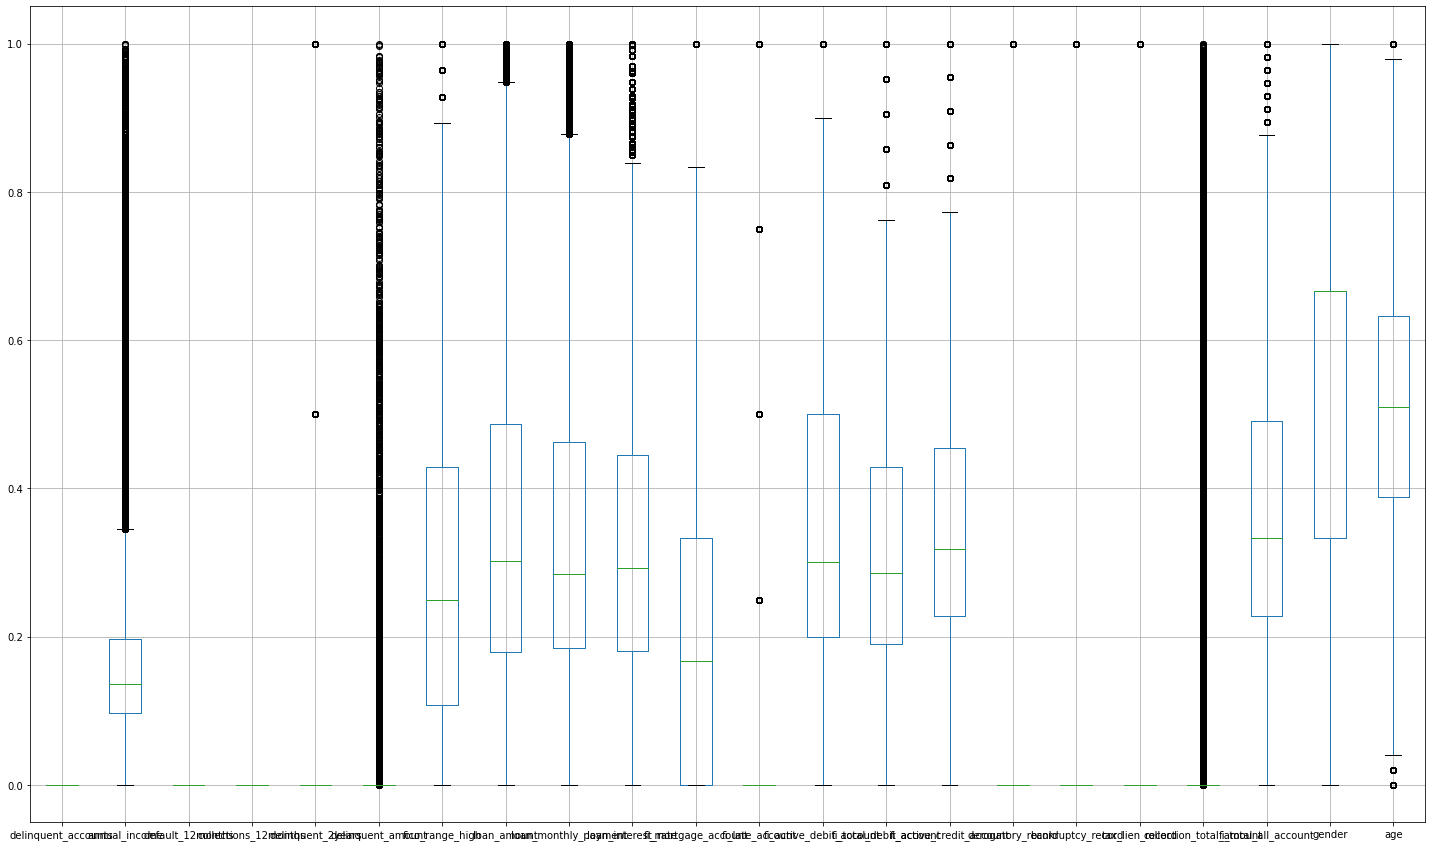

In [85]:
plt.figure(figsize = (25,15))
boxplot = num_df.boxplot()

<AxesSubplot:>

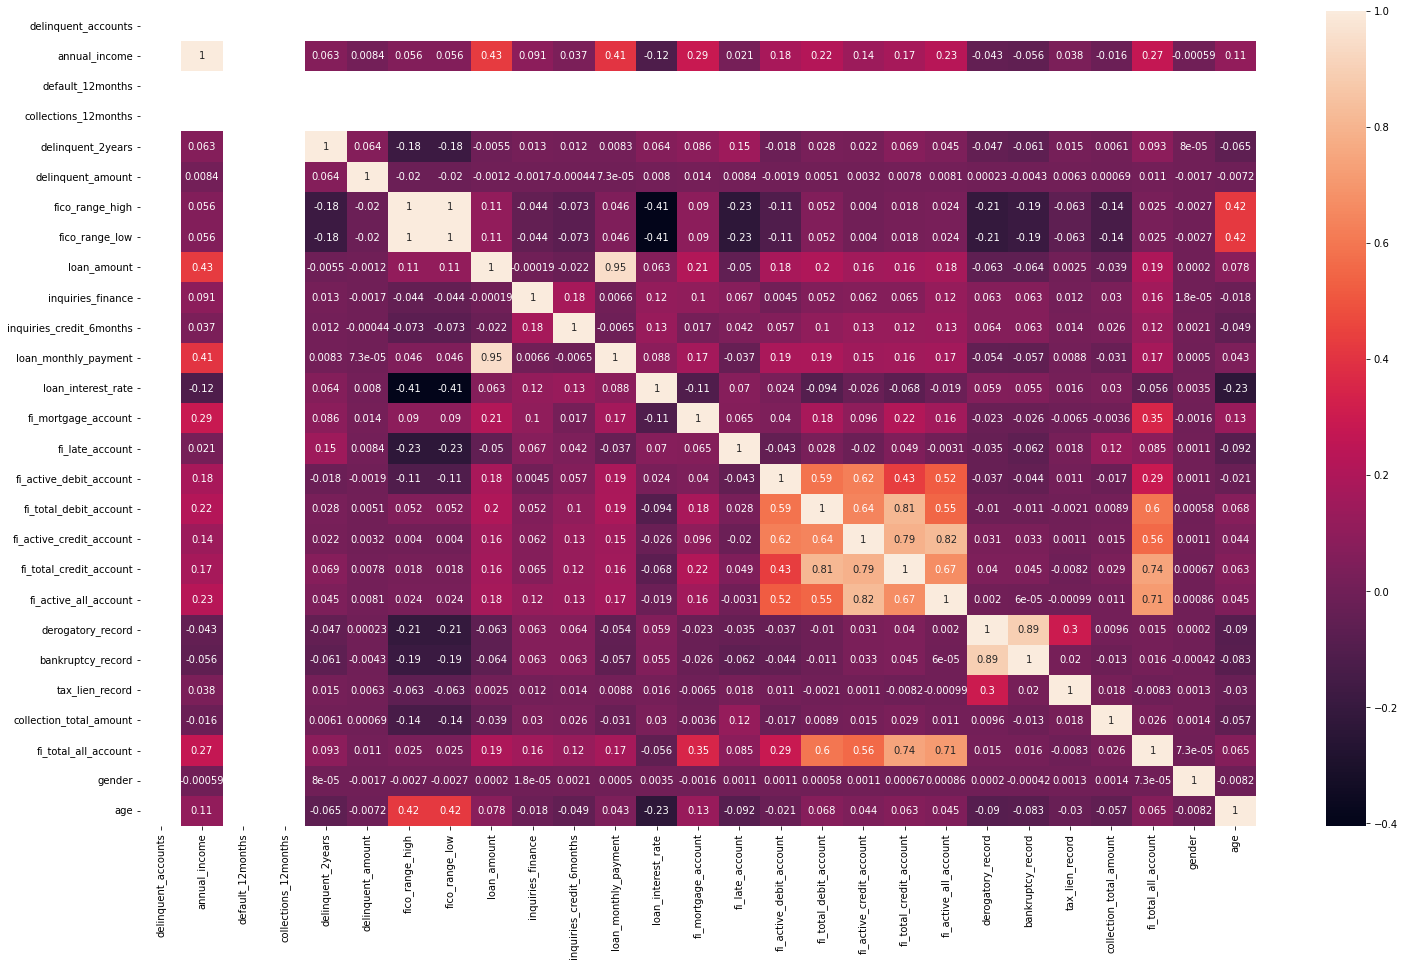

In [49]:
plt.figure(figsize = (25,15))
sns.heatmap(num_df.corr(), annot=True)

In [50]:
num_df = num_df.drop(columns=["fi_active_all_account", "fi_total_credit_account", "fico_range_low", "inquiries_finance", "inquiries_credit_6months"])
num_df.isna().sum().sum()

305168

In [51]:
num_df.dropna()

,delinquent_accounts,annual_income,default_12months,collections_12months,delinquent_2years,delinquent_amount,fico_range_high,loan_amount,loan_monthly_payment,loan_interest_rate,...,fi_active_debit_account,fi_total_debit_account,fi_active_credit_account,derogatory_record,bankruptcy_record,tax_lien_record,collection_total_amount,fi_total_all_account,gender,age
0,0.0,0.086777,0.0,0.0,0.0,0.0,0.392857,0.282051,0.286219,0.116310,...,0.2,0.095238,0.318182,1.0,1.0,0.0,0.0,0.245614,0.333333,0.510204
1,0.0,0.163382,0.0,0.0,0.0,0.0,0.285714,0.384615,0.383595,0.116310,...,0.2,0.095238,0.500000,0.0,0.0,0.0,0.0,0.315789,0.333333,0.448980
2,0.0,0.221074,0.0,0.0,0.0,0.0,0.892857,0.820513,0.788477,0.083078,...,0.4,0.904762,1.000000,0.0,0.0,0.0,0.0,0.877193,0.666667,0.551020
4,0.0,0.247934,0.0,0.0,0.0,0.0,0.750000,1.000000,0.734485,0.425885,...,0.4,0.380952,0.318182,0.0,0.0,0.0,0.0,0.421053,0.333333,0.734694
5,0.0,0.066116,0.0,0.0,0.0,0.0,0.357143,0.153846,0.164494,0.116310,...,0.3,0.285714,0.590909,1.0,1.0,0.0,0.0,0.315789,0.333333,0.489796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495237,0.0,0.123967,0.0,0.0,0.0,0.0,0.428571,0.282051,0.303769,0.291648,...,0.6,0.285714,0.590909,1.0,1.0,0.0,0.0,0.350877,1.000000,0.142857
495238,0.0,0.148760,0.0,0.0,0.0,0.0,0.000000,0.051282,0.081202,0.659379,...,0.5,0.333333,0.500000,0.0,0.0,0.0,0.0,0.192982,0.666667,0.489796
495239,0.0,0.109244,0.0,0.0,0.0,0.0,0.000000,0.333333,0.376678,0.467862,...,0.5,0.476190,0.363636,1.0,1.0,0.0,0.0,0.315789,0.333333,0.530612
495240,0.0,0.260331,0.0,0.0,0.0,0.0,0.571429,0.166667,0.184647,0.244425,...,0.9,0.761905,0.681818,0.0,0.0,0.0,0.0,0.508772,0.666667,0.653061


In [76]:
num_df = num_df.drop(columns=["delinquent_accounts", "default_12months", "collections_12months"])

KeyError: "['delinquent_accounts, default_12months, collections_12months'] not found in axis"

<AxesSubplot:>

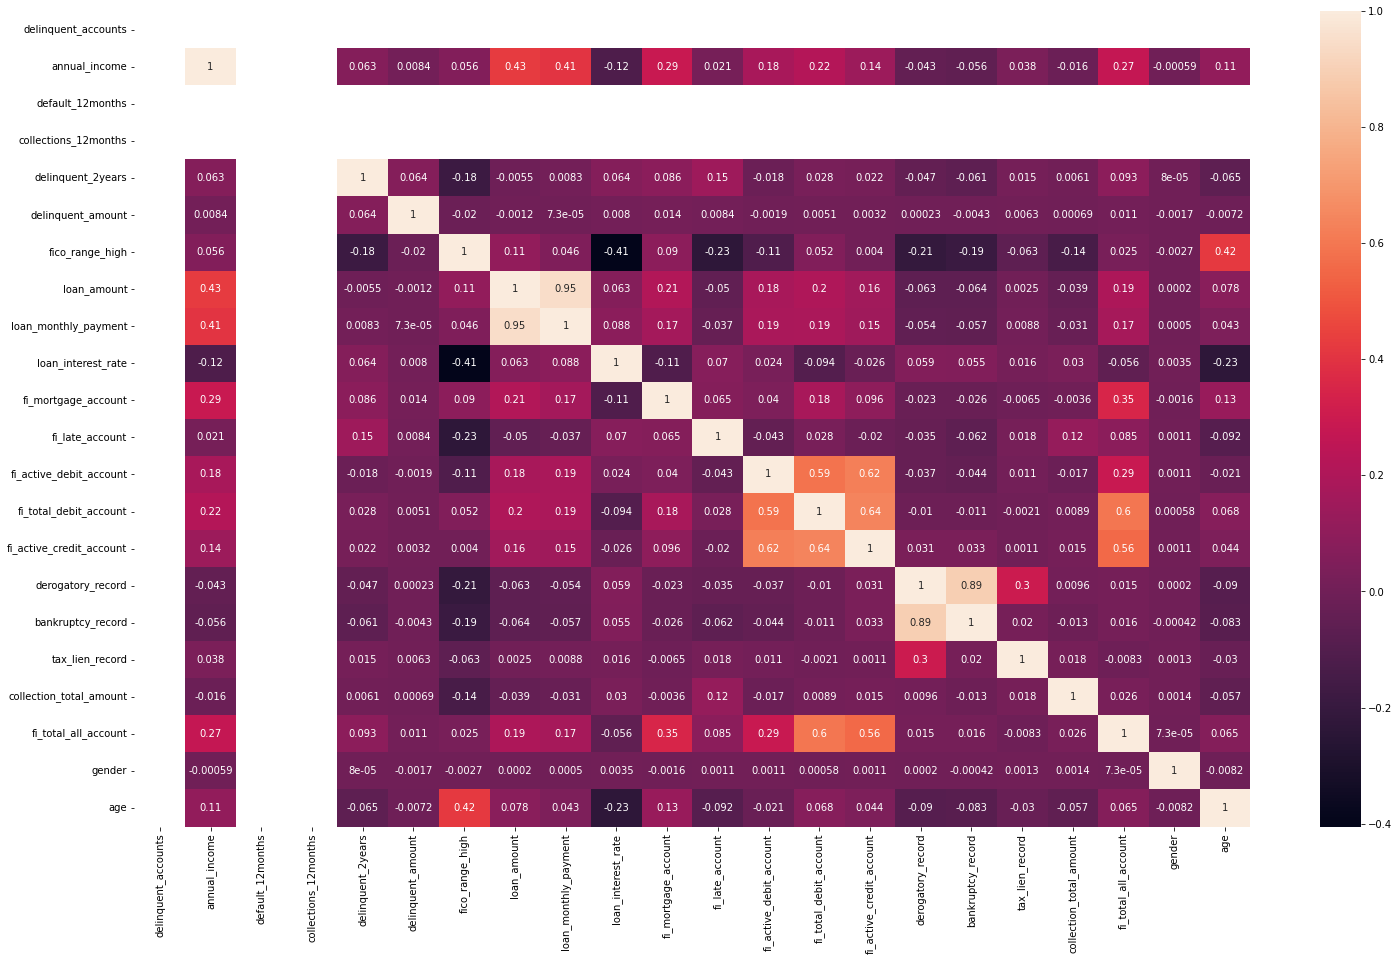

In [53]:
plt.figure(figsize = (25,15))
sns.heatmap(num_df.corr(), annot=True)

In [54]:
categorical_cols = list(cat_df.columns)

categor_df = pd.get_dummies(cat_df, columns=categorical_cols)
categor_df.dropna()

,borrower_state_AK,borrower_state_AL,borrower_state_AR,borrower_state_AZ,borrower_state_CA,borrower_state_CO,borrower_state_CT,borrower_state_DC,borrower_state_DE,borrower_state_FL,...,loan_title_Home improvement,loan_title_Learning and training,loan_title_Major purchase,loan_title_Medical expenses,loan_title_Moving and relocation,loan_title_Other,loan_title_Vacation,annual_income_verified_Not Verified,annual_income_verified_Source Verified,annual_income_verified_Verified
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495237,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
495238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
495239,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
495240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [55]:
categor_df.columns=categor_df.columns.str.replace('[#,@,&,<,>,+,-]','')
categor_df.columns=categor_df.columns.str.replace(' ','_')

C:\Users\zonii\AppData\Local\Temp\ipykernel_19772\3013756229.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  categor_df.columns=categor_df.columns.str.replace('[#,@,&,<,>,+,-]','')


<AxesSubplot:>

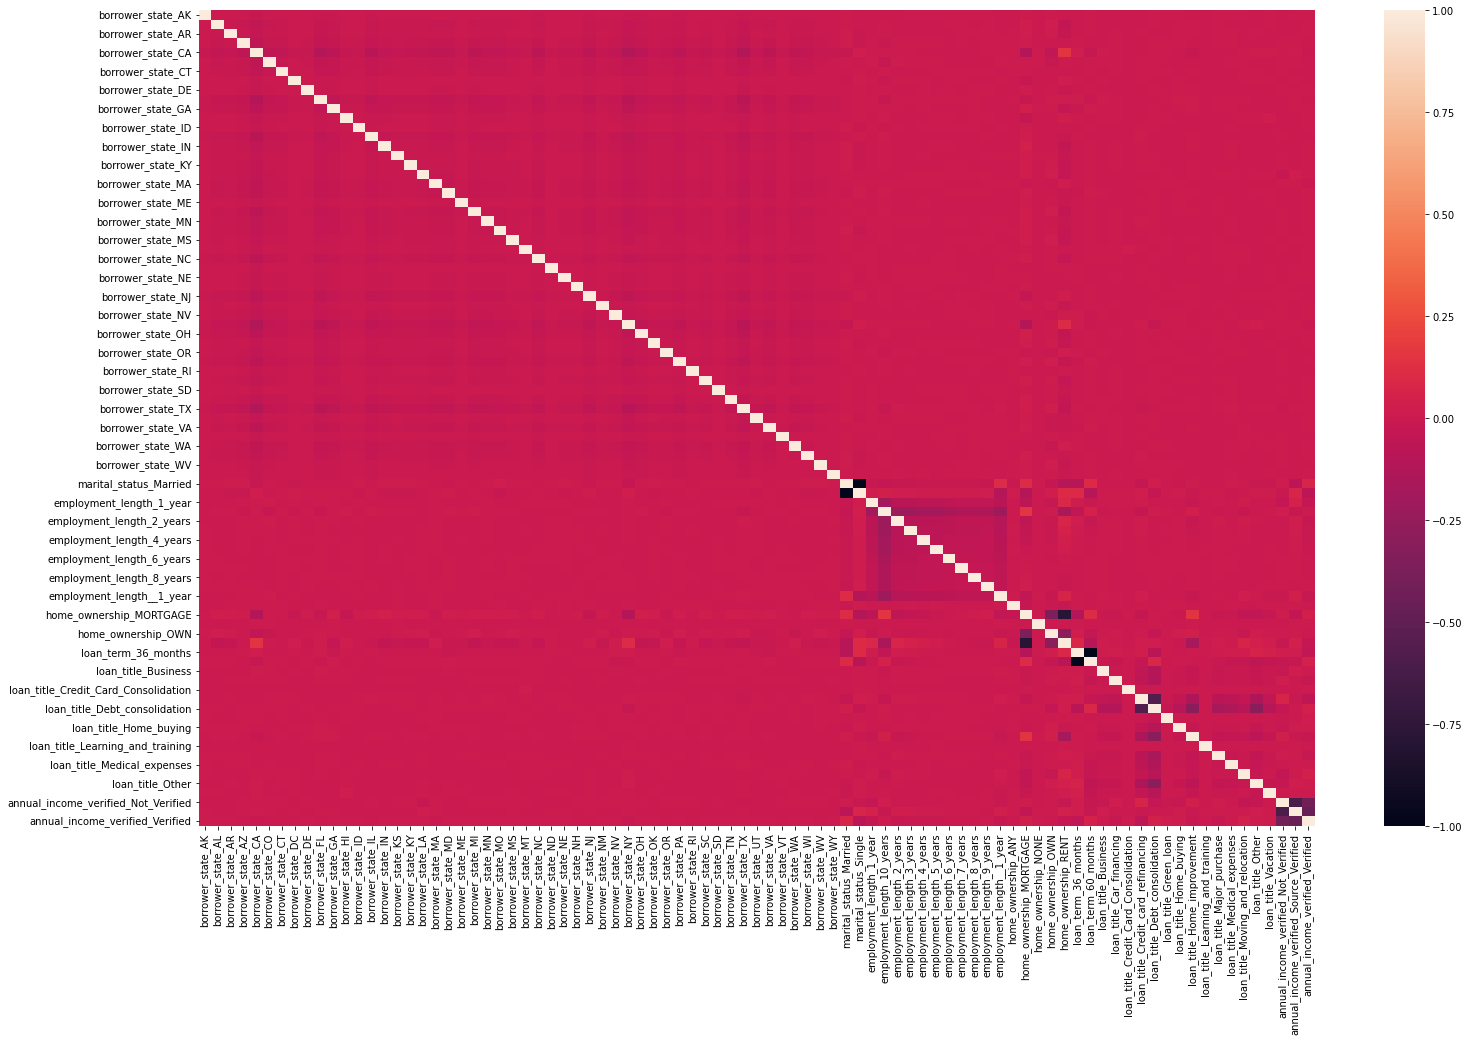

In [56]:
plt.figure(figsize = (25,15))
sns.heatmap(categor_df.corr())

In [57]:
final_df = pd.concat([num_df, categor_df], axis=1)

final_first_df = pd.concat([final_df.iloc[:877986], df["loan_status"]], axis=1)
final_second_df = final_df.iloc[877986:]

In [58]:
final_first_df = final_first_df[final_first_df["loan_status"]!="Current"]
final_first_df["loan_status"].value_counts()

Paid       355005
Default    127069
Name: loan_status, dtype: int64

In [59]:
final_first_df.isna().sum()

delinquent_accounts                        2678
annual_income                               936
default_12months                           4095
collections_12months                       9774
delinquent_2years                         14498
                                          ...  
loan_title_Vacation                           0
annual_income_verified_Not_Verified           0
annual_income_verified_Source_Verified        0
annual_income_verified_Verified               0
loan_status                                   0
Length: 110, dtype: int64

In [60]:
X = final_first_df.drop(columns=['loan_status'])
y = final_first_df["loan_status"]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X,  y,  random_state=0, test_size=0.5, stratify=y
)

In [62]:
#testing to see if there are any columns that are in the training set, but not in the testing set
training_cols = set(X_train.columns)
real_cols = set(final_second_df.columns)

print(list(training_cols-real_cols))

[]


In [63]:
list(X_train.columns)

['delinquent_accounts',
 'annual_income',
 'default_12months',
 'collections_12months',
 'delinquent_2years',
 'delinquent_amount',
 'fico_range_high',
 'loan_amount',
 'loan_monthly_payment',
 'loan_interest_rate',
 'fi_mortgage_account',
 'fi_late_account',
 'fi_active_debit_account',
 'fi_total_debit_account',
 'fi_active_credit_account',
 'derogatory_record',
 'bankruptcy_record',
 'tax_lien_record',
 'collection_total_amount',
 'fi_total_all_account',
 'gender',
 'age',
 'borrower_state_AK',
 'borrower_state_AL',
 'borrower_state_AR',
 'borrower_state_AZ',
 'borrower_state_CA',
 'borrower_state_CO',
 'borrower_state_CT',
 'borrower_state_DC',
 'borrower_state_DE',
 'borrower_state_FL',
 'borrower_state_GA',
 'borrower_state_HI',
 'borrower_state_ID',
 'borrower_state_IL',
 'borrower_state_IN',
 'borrower_state_KS',
 'borrower_state_KY',
 'borrower_state_LA',
 'borrower_state_MA',
 'borrower_state_MD',
 'borrower_state_ME',
 'borrower_state_MI',
 'borrower_state_MN',
 'borrower_sta

In [64]:
params={
'scale_pos_weight':[10000, 11000, 12000, 14000, 15000],
'colsample_bytree':[0.7, 0.8, 0.9],
'learning_rate':[0.1, 0.15, 0.175, 0.2],
'max_depth':[3, 4, 5],
'min_child_weight':[2, 3, 4],
'gamma':[0.05, 0.1, 0.15]
}

In [65]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', gpu_id=0, scale_pos_weight=11000, colsample_bytree=0.9, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3)

The following HalvingCV functions where a way to reduce the amount of time to hyperparameter tun the model and to avoid using GridSearchCV, this is an exeprimental function within the sklearn library

In [66]:
#halving_cv = HalvingGridSearchCV(xgb_cl, params, scoring="roc_auc", n_jobs=-1, min_resources="exhaust", factor=3)
#halving_cv.fit(X_train, y_train)

In [67]:
#halving_cv.best_params_ 

In [106]:
xgb_cl.fit(X_train, y_train)

preds = xgb_cl.predict(X_test)

print(preds[1:10])
print(y_test[1:10])

print(classification_report(y_test, preds, target_names=["Paid", "Default"]))

C:\Users\zonii\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
['Paid' 'Paid' 'Paid' 'Paid' 'Paid' 'Paid' 'Paid' 'Paid' 'Paid']
560933       Paid
453531    Default
18966        Paid
419488       Paid
869054       Paid
431773       Paid
142857    Default
169710       Paid
617629       Paid
Name: loan_status, dtype: object
              precision    recall  f1-score   support

        Paid       0.98      0.00      0.00     63535
     Default       0.74      1.00      0.85    177502

    accuracy                           0.74    241037
   macro avg       0.86      0.50      0.43    241037
weighted avg       0.80      0.74      0.63    241037



In [107]:
#This cell is specifically for Matt to check for some things

#preds_data = xgb_cl.predict_proba(X)
#preds_df = pd.DataFrame(preds_data)

#matt = pd.concat([X, preds_df], axis=1, join="inner")
#matt.to_csv("datasets/matt_predictions.csv")

<AxesSubplot:>

<Figure size 1800x1800 with 0 Axes>

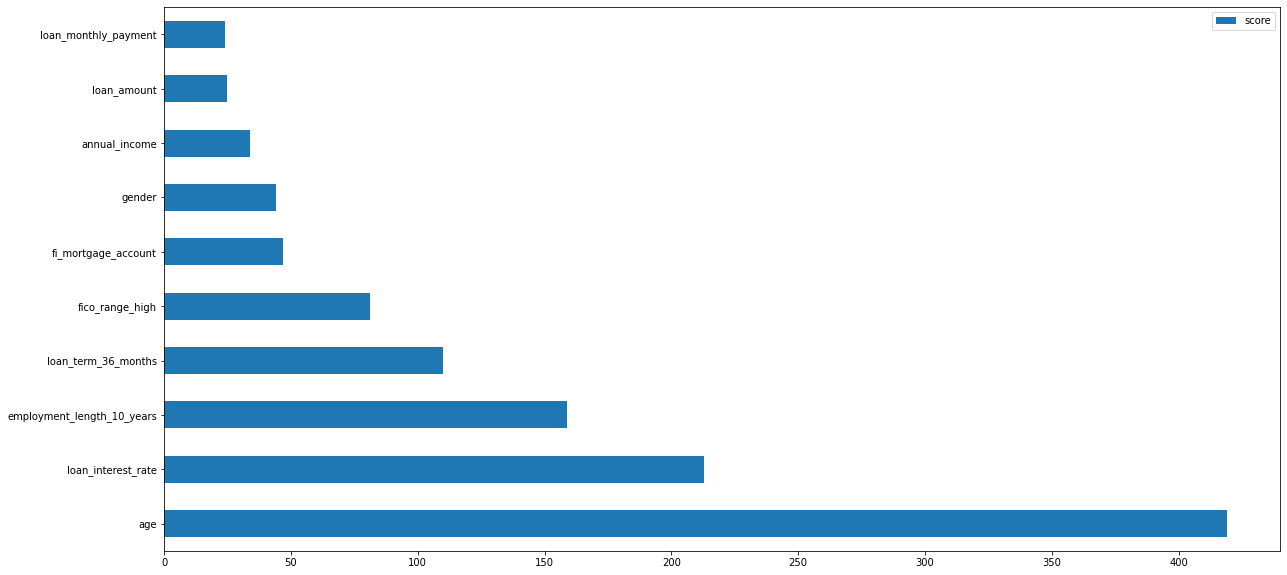

In [117]:
plt.figure(figsize = (25,25))

feature_important = xgb_cl.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10))

In [70]:
final_preds = list(xgb_cl.predict(final_second_df))

modified_predictions = []

for i in list(final_preds):
    if i == "Paid":
        modified_predictions.append(0)
    else:
        modified_predictions.append(1)

In [71]:
data = {"loanID":df2["loanID"],
        "default":modified_predictions}

print(len(modified_predictions))
final_df = pd.DataFrame(data)
final_df.set_index("loanID", inplace=True)
final_df
final_df.to_csv("datasets/final_xgb.csv",)

495242
